In [2]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
torch.manual_seed(1)    # reproducible
TIME_STEP = 10      # rnn time step
INPUT_SIZE = 1      # rnn input size
LR = 0.02           # learning rate

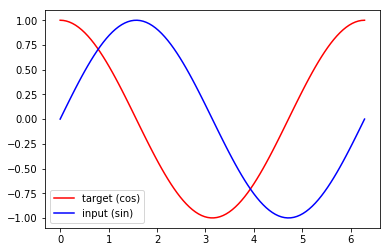

In [4]:
steps = np.linspace(0, np.pi*2, 100, dtype=np.float32)
x_np = np.sin(steps)    # float32 for converting torch FloatTensor
y_np = np.cos(steps)
plt.plot(steps, y_np, 'r-', label='target (cos)')
plt.plot(steps, x_np, 'b-', label='input (sin)')
plt.legend(loc='best')
plt.show()

In [6]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()  
        self.rnn = nn.RNN(
            input_size=INPUT_SIZE, # 用一个时间点的y值学习并预测另一个时间点y值，因此input_size和output_size都是1
            hidden_size=32,
            num_layers=1,
            batch_first=True
        )
        self.out = nn.Linear(32, 1)
        
    def forward(self, x, h_state):
        # shape of x: (batch, time_step, input_size)
        # shape of h_state: (n_layers, batch, hidden_size)
        # shape of r_out: (batch, time_step, hidden_size)
        r_out, h_state = self.rnn(x, h_state)
        outs = []
        for time_step in range(r_out.size(1)):
            outs.append(self.out(r_out[:, time_step, :]))
        # 由于outs是一个list，因此使用torch.stack将其压缩成tensor传入下一个RNN单元中
        return torch.stack(outs, dim=1), h_state
        
rnn = RNN()
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (out): Linear(in_features=32, out_features=1, bias=True)
)


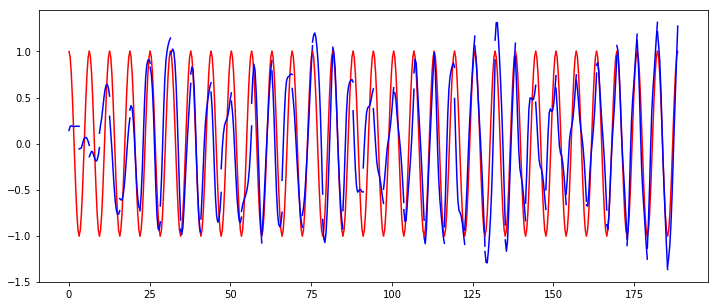

In [7]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=LR)
loss_func = nn.MSELoss()
# h_state初始化为None
h_state = None
plt.figure(1, figsize=(12, 5))
plt.ion()

for step in range(60):
    start, end = step * np.pi, (step+1)*np.pi
    steps = np.linspace(start, end, TIME_STEP, dtype=np.float32)
    x_np = np.sin(steps)
    y_np = np.cos(steps)
    
    x = torch.from_numpy(x_np[np.newaxis, :, np.newaxis]) # shape (batch, time_step, input_size)
    y = torch.from_numpy(y_np[np.newaxis, :, np.newaxis])
    
    prediction, h_state = rnn(x, h_state)
    h_state = h_state.data
    loss = loss_func(prediction, y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    plt.plot(steps, y_np.flatten(), 'r-')
    plt.plot(steps, prediction.data.numpy().flatten(), 'b-')
    plt.draw()
    plt.pause(0.05)